## Discretisation with Decision Trees using Feature-Engine


feature Engine allows you to implement decision tree discretisation on all your numerical variables very easily, including search over the multiple parameters of the decision tree, to find the best one.

## In this demo

We will learn how to perform discretisation with decision trees and Feature-Engine using the Titanic dataset.

### Titanic dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisers import DecisionTreeDiscretiser

In [2]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv('../titanic.csv',
                   usecols = ['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

In [4]:
def impute_na(data, variable):
    df = data.copy()

    # random sampling
    df[variable+'_random'] = df[variable]
    
    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample

    return df[variable+'_random']

In [5]:
# replace NA in both  train and test sets

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [6]:
X_train.head()

,age,fare
501,13.0,19.5000
588,4.0,23.0000
402,30.0,13.8583
1193,21.0,7.7250
686,22.0,7.7250


In [7]:
# set up the decision tree discretiser indicating:
# cross-validation number (cv)
# how to evaluate model performance (scoring)
# the variables we want to discretise (variables)
# whether it is a target for regression or classification
# and the grid with the parameters we want to test

treeDisc = DecisionTreeDiscretiser(cv=10, scoring='accuracy',
                                   variables=['age', 'fare'],
                                   regression=False,
                                   param_grid={'max_depth': [1, 2, 3],
                                              'min_samples_leaf':[10,4]})

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=10,
                        param_grid={'max_depth': [1, 2, 3],
                                    'min_samples_leaf': [10, 4]},
                        random_state=None, regression=False, scoring='accuracy',
                        variables=['age', 'fare'])

In [8]:
# we can inspect the tree for age
treeDisc.binner_dict_['age'].best_params_

{'max_depth': 2, 'min_samples_leaf': 4}

In [9]:
# and the performance obtained on the train set while fitting

treeDisc.scores_dict_['age']

0.618995633187773

In [10]:
# and the best parameters for fare
treeDisc.binner_dict_['fare'].best_params_

{'max_depth': 3, 'min_samples_leaf': 10}

In [11]:
# and the performance obtained on the train set while fitting

treeDisc.scores_dict_['fare']

0.6888646288209607

By comparing the accuracy of the decision trees for age and fare, we can derive that fare is a better indicator of the outcome survived.

In [12]:
# let's transform the data

train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

In [13]:
# let's inspect how many bins we found

train_t['age'].unique()

array([0.38011696, 0.53846154, 0.        ])

Text(0, 0.5, 'Survived')

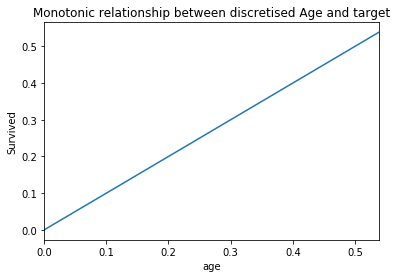

In [14]:
# monotonic relationship with target: train set

pd.concat([train_t, y_train], axis=1).groupby(['age'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

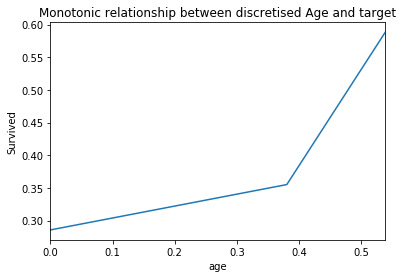

In [15]:
# monotonic relationship with target: test set

pd.concat([test_t, y_test], axis=1).groupby(['age'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Our tree kept the monotonic relationship between bins and target. I have to say that I needed to play quite a bit with the parameters of the tree to find the optimal tree, to keep the monotonic relationship. But, it is the trade off, like from anything else in life :)

Text(0, 0.5, 'Survived')

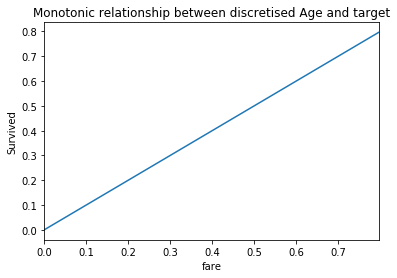

In [16]:
# let's explore the monotonic relationship for fare
pd.concat([train_t, y_train], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

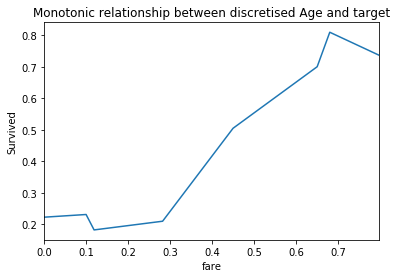

In [17]:
# monotonic relationship with target: test set

pd.concat([test_t, y_test], axis=1).groupby(['fare'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

For fare, the monotonic relationship was preserved, almost entirely, except at the edges, which suggests that the tree could be overfitting to the train set.

Text(0, 0.5, 'Number of observations per bin')

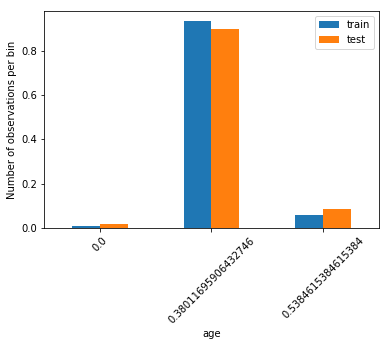

In [18]:
# let's explore how many observations we have per bin

t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

Most of the observations are in the middle bucket, which indicates that this variable is not very predictive. 

Text(0, 0.5, 'Number of observations per bin')

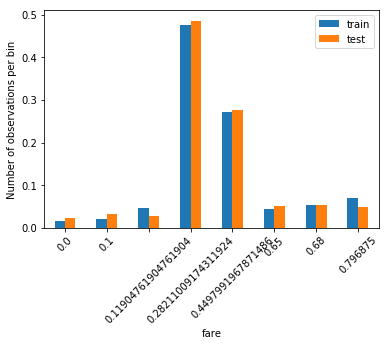

In [19]:
# let's explore how many observations we have per bin

t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

For fare, the tree sorted the values in more buckets, therefore creating a better value spread (remember that fare was quite skewed).